In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import normaltest

Мы предполагаем, что доля знаков пунктуации в сообщениях ботов и троллей больше чем в обычных комментариях.

In [ ]:
with open('drive/MyDrive/Diplom/train.csv') as f:
    ds = pd.read_csv(f,sep='\t')

In [ ]:
import re

pattern = '[^a-zA-Z0-9\t\n\r\f\v]'

def num_punct_symbols(text):
  return(len(re.findall(pattern, text)))

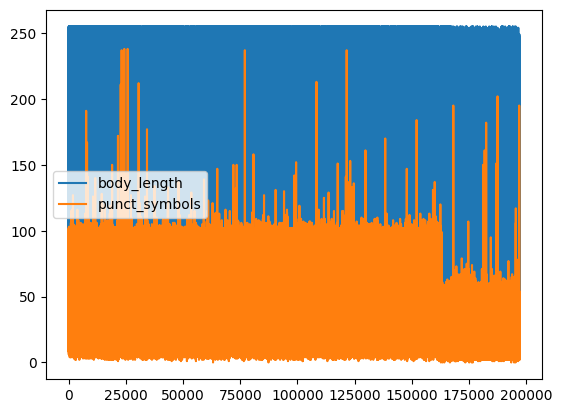

In [ ]:
ds['body_length'] = ds['body'].apply(lambda x: len(x))
ds['punct_symbols'] = ds['body'].apply(num_punct_symbols)
ds[['body_length','punct_symbols']].plot(kind='line')
ds['punct_symbols_frac'] = ds['punct_symbols']/ds['body_length']

In [ ]:
bots = ds[ds.Y == 0].sample(n=51374,random_state=32,ignore_index=True)
not_bots = ds[ds.Y != 0]

<Axes: >

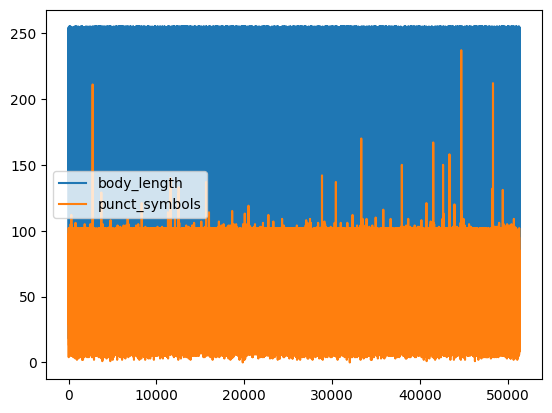

In [ ]:
bots[['body_length','punct_symbols']].plot(kind='line')

<Axes: >

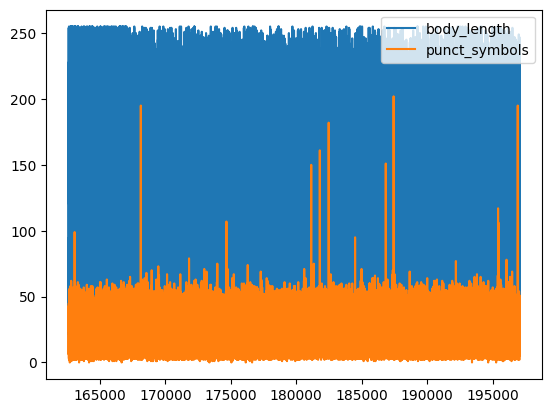

In [ ]:
not_bots[['body_length','punct_symbols']].plot(kind='line')

Посмотрим какому закону распределения соответствует сэмпл с ботами. Попробуем нормальное и гамма распределения.

In [ ]:
from scipy.stats import gamma, kstest

In [ ]:
res = kstest(bots['punct_symbols_frac'],  'gamma', args=(7.4, 0.11, 1./50))
res

KstestResult(statistic=0.08243879137961818, pvalue=3.5868164116801515e-304, statistic_location=0.35, statistic_sign=-1)

In [ ]:
from scipy.stats import gamma, kstest

np.random.seed(123)

sample = gamma.rvs(a=7.4, loc=0.104, scale=1./50, size=51374)

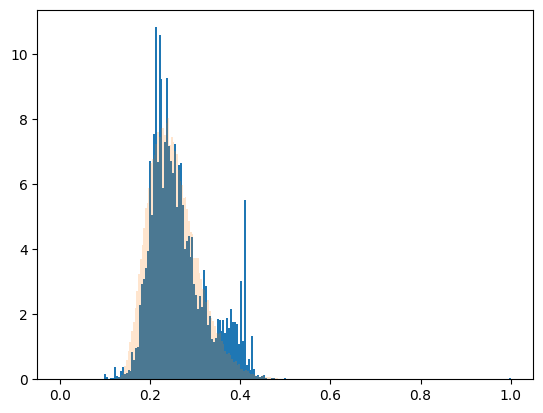

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(bots['punct_symbols_frac'], density=True, bins='auto', histtype='stepfilled')
ax.hist(sample, density=True, bins='auto', histtype='stepfilled', alpha = 0.2)
plt.show()

In [ ]:
res = kstest(bots['punct_symbols_frac'],  'norm', args=(0.24, 1./27))
res

KstestResult(statistic=0.19944454794345745, pvalue=0.0, statistic_location=0.29365079365079366, statistic_sign=-1)

In [ ]:
from scipy.stats import norm, kstest

np.random.seed(123)

sample = norm.rvs(loc=0.24, scale=1./27, size=51374)

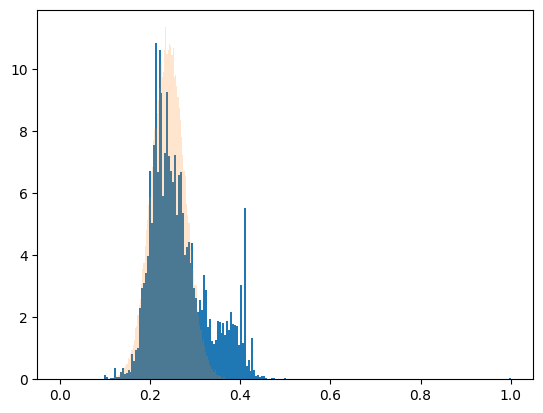

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(bots['punct_symbols_frac'], density=True, bins='auto', histtype='stepfilled')
ax.hist(sample, density=True, bins='auto', histtype='stepfilled', alpha = 0.2)
plt.show()

Т.к. распределение одной из выборок не является нормальным, надо будет выбрать такие тесты, которые не требуют нормально распределенных данных.

Непарный t-тест: используется для сравнения средних значений двух выборок, когда каждый человек в одной выборке не зависит от каждого человека в другой выборке.

Для t-test нормальным должно быть распределение среднего значения метрики в группе, этого достаточно, если сама группа достаточн большая. 

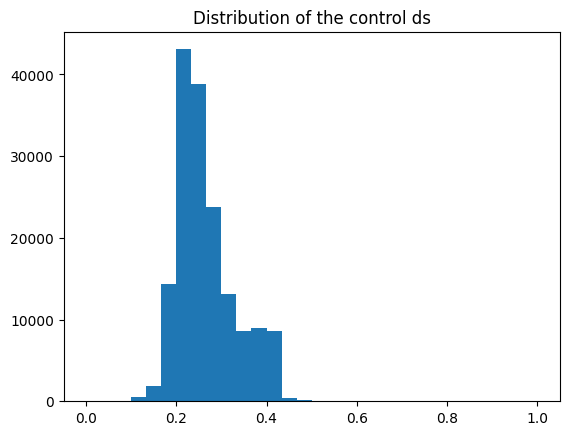

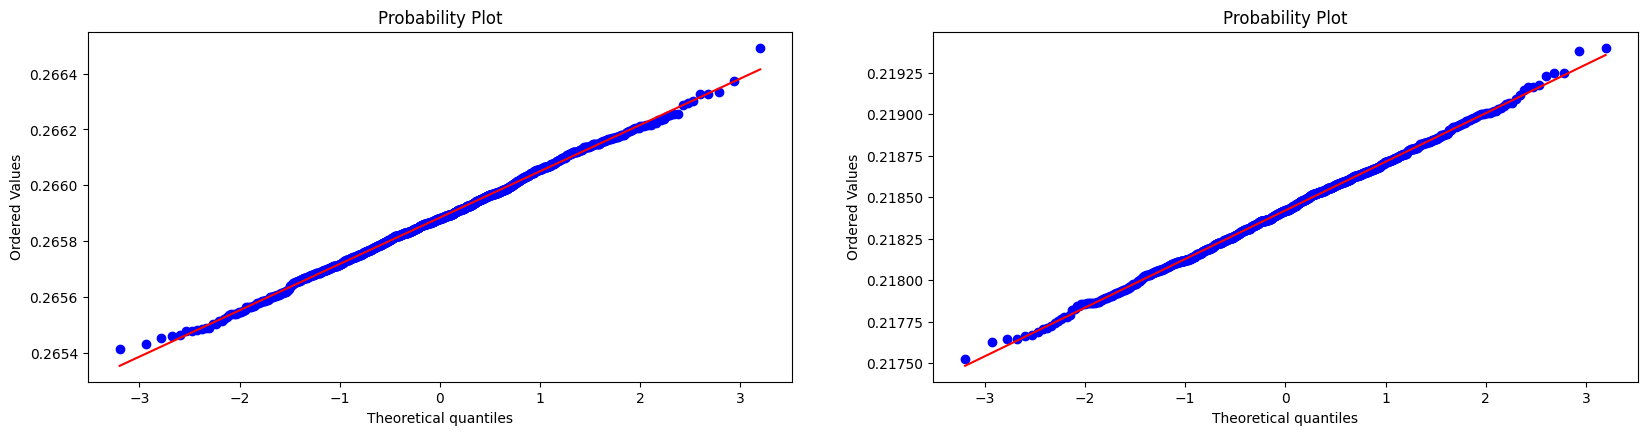

Тест на нормальность распределения control группы: W = 0.998 , p-value = 0.498 => не стат значимо, нормальное
Тест на нормальность распределения target группы: W = 0.999 , p-value = 0.877 => не стат значимо, нормальное


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import pylab
from pylab import *

sample_means_control = []
sample_means_target = []

for i in range(1000):
  sample_control = ds.loc[ds.Y == 0, 'punct_symbols_frac'].sample(frac=1, replace=True)
  sample_target = ds.loc[ds.Y != 0, 'punct_symbols_frac'].sample(frac=1, replace=True)
  sample_means_control.append(sample_control.mean())
  sample_means_target.append(sample_target.mean())
  
# Plot the population
count, bins, ignored = plt.hist(sample_control, 30)
plt.title('Distribution of the control ds')
plt.show()

# Q-Q plots for control and target groups
pylab.figure(figsize=(20,10))
pylab.subplot(2,2,1)
stats.probplot(sample_means_control, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(sample_means_target, dist="norm", plot=pylab)
pylab.show()

# check for normality by Shapiro-Wilk test
sp = stats.shapiro(sample_means_control)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = stats.shapiro(sample_means_target)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения target группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)


Следовательно я могу применять Т-тест 

The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true. A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means.

In [ ]:
stats.ttest_ind(bots['punct_symbols_frac'], not_bots['punct_symbols_frac'])

Ttest_indResult(statistic=112.07764259751032, pvalue=0.0)

If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. If False, perform Welch’s t-test, which does not assume equal population variance [2].

In [ ]:
stats.ttest_ind(bots['punct_symbols_frac'], not_bots['punct_symbols_frac'], equal_var=False)

Ttest_indResult(statistic=117.78017328993592, pvalue=0.0)

0 < 0.5 => отклоняем H0 => среднее выборок сильно отличаются, они не из одной популяции